# Stock Analysis with TensorFlow

This notebook demonstrates how to create time series analysis and forecasts for stock prices using LSTM networks (Long Short-Term Memory). We use TensorFlow and Keras to compare different model architectures.

## Configuration
The first cell below contains all configurable parameters. Adjust them to analyze different stocks or change model behaviors.

In [5]:
# ======================= CONFIGURATION CELL =======================
# Modify these parameters to customize your analysis

# Stock data parameters

# TICKER = "PUM.DE"        # PUMA (German Stock Exchange)
# TICKER = "DTE.DE"      # Deutsche Telekom (German Stock Exchange)
TICKER = "EOAN.DE"       # E.ON (German Stock Exchange)
# Alternative tickers:
# TICKER = "EONGY"       # E.ON (US ADR)
# TICKER = "HO.PA"       # Thales (Paris Stock Exchange)
# TICKER = "SAP.DE"      # SAP 
# TICKER = "VOW.DE"      # Volkswagen
# TICKER = "BTC-USD"     # Bitcoin

# Company/Asset name for plot titles (automatically set based on ticker, but can be overridden)
ASSET_NAME = ""          # Leave empty to use default naming based on ticker

# Define a function to get a friendly asset name from the ticker
def get_asset_name(ticker):
    asset_mapping = {
        "EOAN.DE": "E.ON",
        "EONGY": "E.ON (US)",
        "HO.PA": "Thales",
        "SAP.DE": "SAP",
        "VOW.DE": "Volkswagen",
        "BTC-USD": "Bitcoin",
        "DTE.DE": "Deutsche Telekom"
    }
    return asset_mapping.get(ticker, ticker)

# Set the asset name based on ticker if not explicitly provided
if not ASSET_NAME:
    ASSET_NAME = get_asset_name(TICKER)

# Date range (years of historical data to analyze)
YEARS_OF_HISTORY = 10    # Number of years of historical data to download

# Data preparation parameters
WINDOW_SIZE = 50         # Size of sliding window (days of data to predict the next day)
TRAIN_RATIO = 0.85       # Proportion of data used for training (0.85 = 85%)
USE_LOG_RETURNS = False  # Whether to use logarithmic returns instead of percentage changes

# Model training parameters
EPOCHS = 30              # Maximum number of training epochs
BATCH_SIZE = 32          # Batch size for training
VALIDATION_SPLIT = 0.2   # Portion of training data used for validation (0.2 = 20%)
PATIENCE = 10            # Patience for early stopping (stop training if no improvement)

# LSTM model parameters
LSTM_UNITS = 64          # Number of LSTM units (neurons) in each layer
DROPOUT_RATE = 0.3       # Dropout rate for regularization
LEARNING_RATE = 0.001    # Learning rate for Adam optimizer
LSTM_LAYERS = 2          # Number of LSTM layers in the stacked model
USE_BIDIRECTIONAL = True # Whether to use bidirectional LSTM

# Window size experiment parameters (if running the last cell)
TEST_WINDOW_SIZES = [10, 25, 50, 75, 100]  # Window sizes to test
TEST_EPOCHS = 20         # Epochs for each window size test

# Visualization parameters
LARGE_FIG_SIZE = (14, 7)   # Size for larger figures (width, height in inches)
MEDIUM_FIG_SIZE = (12, 6)  # Size for medium figures
SMALL_FIG_SIZE = (10, 5)   # Size for smaller figures

# Currency symbol for price labels (automatically set based on ticker)
CURRENCY = ""  # Leave empty to use default based on ticker

# Define a function to get the currency symbol based on ticker
def get_currency_symbol(ticker):
    # Default mappings based on common ticker suffixes
    if ticker.endswith(".DE") or ticker.endswith(".PA") or ticker.endswith(".EU"):
        return "€"  # Euro for European exchanges
    elif ticker.endswith("USD") or "." not in ticker:
        return "$"  # Dollar for USD or US exchanges (default)
    elif ticker.endswith(".L"):
        return "£"  # Pound for London exchange
    elif ticker.endswith(".HK"):
        return "HK$"  # Hong Kong Dollar
    elif ticker.endswith(".JP"):
        return "¥"  # Yen for Japanese exchanges
    else:
        return "$"  # Default to USD

# Set currency if not explicitly provided
if not CURRENCY:
    CURRENCY = get_currency_symbol(TICKER)

# Print configuration summary
print(f"Analysis configured for {ASSET_NAME} ({TICKER}) with {YEARS_OF_HISTORY} years of history")
print(f"Using window size of {WINDOW_SIZE} days with {TRAIN_RATIO*100:.0f}%/{(1-TRAIN_RATIO)*100:.0f}% train/test split")
print(f"Models will use {LSTM_LAYERS} {'bidirectional ' if USE_BIDIRECTIONAL else ''}LSTM layers with {LSTM_UNITS} units each")

Analysis configured for E.ON (EOAN.DE) with 10 years of history
Using window size of 50 days with 85%/15% train/test split
Models will use 2 bidirectional LSTM layers with 64 units each


In [6]:
# Check if TensorFlow is already installed
try:
    import tensorflow as tf
    print(f"TensorFlow already installed, version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    %pip install tensorflow

# Install other required packages
%pip install yfinance pandas matplotlib scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define date range based on configuration
end_date = datetime.now()
start_date = end_date - timedelta(days=365*YEARS_OF_HISTORY)

# Download data using the configured ticker
ticker = TICKER
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of data
print(f"Downloaded {len(stock_data)} days of data for {ticker}")
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 2541 days of data for EOAN.DE


Price,Close,High,Low,Open,Volume
Ticker,EOAN.DE,EOAN.DE,EOAN.DE,EOAN.DE,EOAN.DE
Date,,,,,
2015-05-06,7.770372,7.795961,7.679391,7.739098,12648778
2015-05-07,7.963706,7.972235,7.778901,7.864195,17541851
2015-05-08,8.281402,8.290282,7.991345,8.032783,17031863
2015-05-11,8.293242,8.334678,8.222208,8.257724,8174094
2015-05-12,8.204450,8.254765,8.100858,8.207409,11014540


### Data Acquisition Explanation:

The code above performs the following steps:

1. **Check TensorFlow Installation**: We check if TensorFlow is already installed and install it if needed.
2. **Install Dependencies**: We install all necessary packages like `yfinance` for stock data, `pandas` for data manipulation, etc.
3. **Define Time Period**: We define a time period based on the configured years of history.
4. **Download Data**: Using `yf.download()`, we download stock data from Yahoo Finance for the configured ticker.

The resulting `stock_data` DataFrame contains the columns:
- **Open**: Opening price
- **High**: Daily high
- **Low**: Daily low
- **Close**: Closing price (used for our analysis)
- **Adj Close**: Adjusted closing price
- **Volume**: Trading volume

---

## Data Preparation


To prepare time series data for LSTM models, we need to format the data appropriately. We use a sliding window approach, where we create windows from historical price movements to predict future values.

C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])


Dataset generated successfully!
X_train shape: (2116, 50)
y_train shape: (2116,)
X_test shape: (374, 50)
y_test shape: (374,)


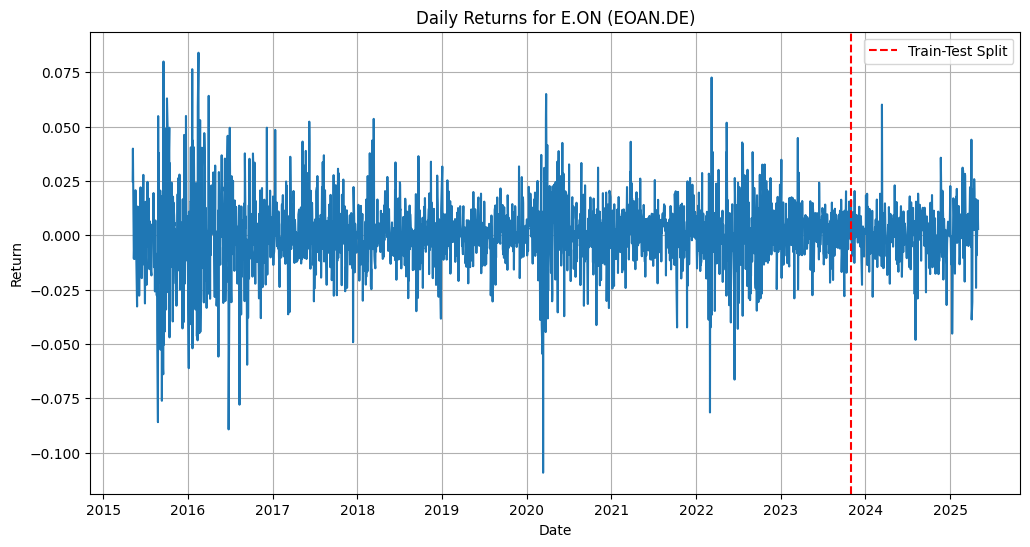

In [7]:
import numpy as np

def generate_dataset(stock_data, ticker, window_size=WINDOW_SIZE, train_ratio=TRAIN_RATIO, use_log_returns=USE_LOG_RETURNS):
    """
    Generate a dataset for predicting stock price changes using sliding window approach.
    
    Parameters:

    -----------
    stock_data : DataFrame with MultiIndex columns
    ticker : ticker symbol 
    window_size : size of sliding window (default: 50 days)
    train_ratio : proportion of data for training (default: 0.85)
    use_log_returns : whether to use log returns instead of percentage changes
    
    Returns:
    --------
    X_train, y_train, X_test, y_test, returns
    """
    # Extract closing prices - handle both regular and MultiIndex DataFrames
    if isinstance(stock_data.columns, pd.MultiIndex):
        close_prices = stock_data[('Close', ticker)]
    else:
        close_prices = stock_data['Close']
    
    # Calculate returns
    if use_log_returns:
        returns = np.log(close_prices / close_prices.shift(1)).dropna()
    else:
        returns = close_prices.pct_change().dropna()
    
    # Create sliding windows
    X, y = [], []
    for i in range(len(returns) - window_size):
        X.append(returns[i:i+window_size].values)
        y.append(returns[i+window_size])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into training and testing sets
    split_point = int(len(X) * train_ratio)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    return X_train, y_train, X_test, y_test, returns

# Generate the dataset
X_train, y_train, X_test, y_test, returns = generate_dataset(stock_data, ticker)

# Print dataset information
print(f"Dataset generated successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Visualize the returns with train-test split
plt.figure(figsize=MEDIUM_FIG_SIZE)
plt.plot(returns.index, returns.values)
plt.title(f'Daily Returns for {ASSET_NAME} ({ticker})')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.axvline(returns.index[int(len(returns) * TRAIN_RATIO)], color='r', linestyle='--', label='Train-Test Split')
plt.legend()
plt.show()

### Explanation:

The `generate_dataset()` function is crucial for preparing our time series data:

1. **Calculate Returns**: percentage changes (`pct_change()`) to normalize the data and make it stationary.
2. **Sliding Window Technique**: 50 days of historical returns (adjustable with `window_size`) to predict the next day.
3. **Train-Test Split**: training (85%) and test sets (15%).

**Visualization**: daily returns with a red line marking the train-test split.

[Time Series Forecasting Guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

---

## LSTM Model Architectures

LSTM networks [(Long Short-Term Memory)](https://de.wikipedia.org/wiki/Long_short-term_memory) are a special type of recurrent neural networks (RNNs) that are particularly well-suited for time series analysis. We implement different LSTM architectures.


Training LSTM model...
Epoch 1/30


C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.8270e-04 - val_loss: 2.0287e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.8270e-04 - val_loss: 2.0287e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.1017e-04 - val_loss: 2.2101e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.1017e-04 - val_loss: 2.2101e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1040e-04 - val_loss: 2.1171e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1040e-04 - val_loss: 2.1171e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.4165e-04 - val_loss: 2.0315e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.4165e-04 - val_loss: 2.0315e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1036e-04 - val_loss: 2.0353e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1036e-04 - val_loss: 2.0353e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.1052e-04 - val_loss:

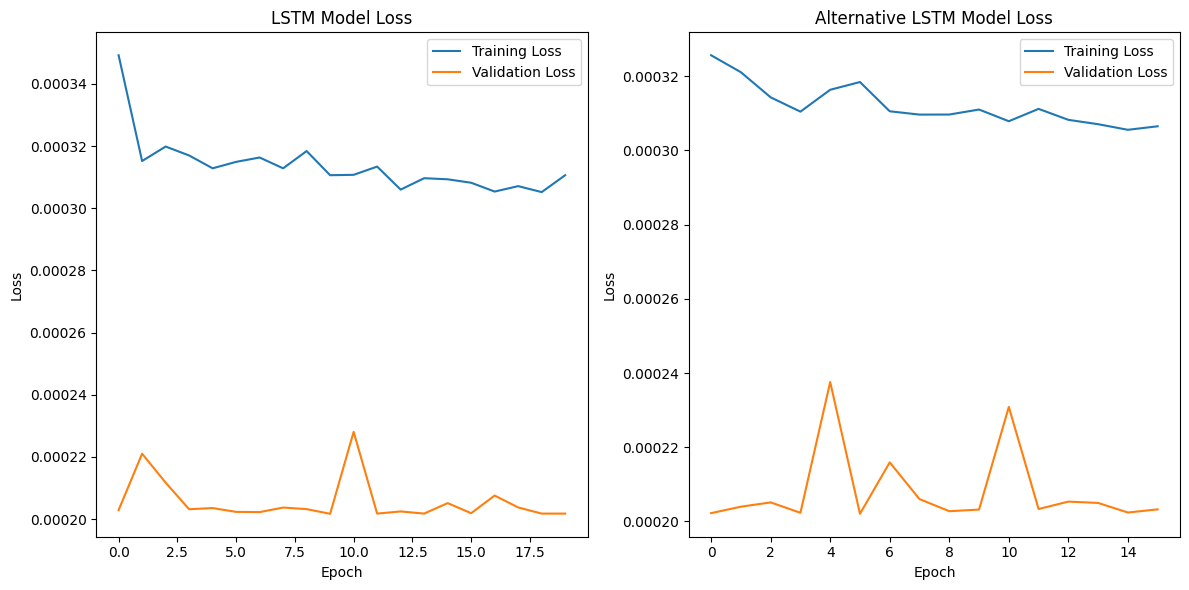

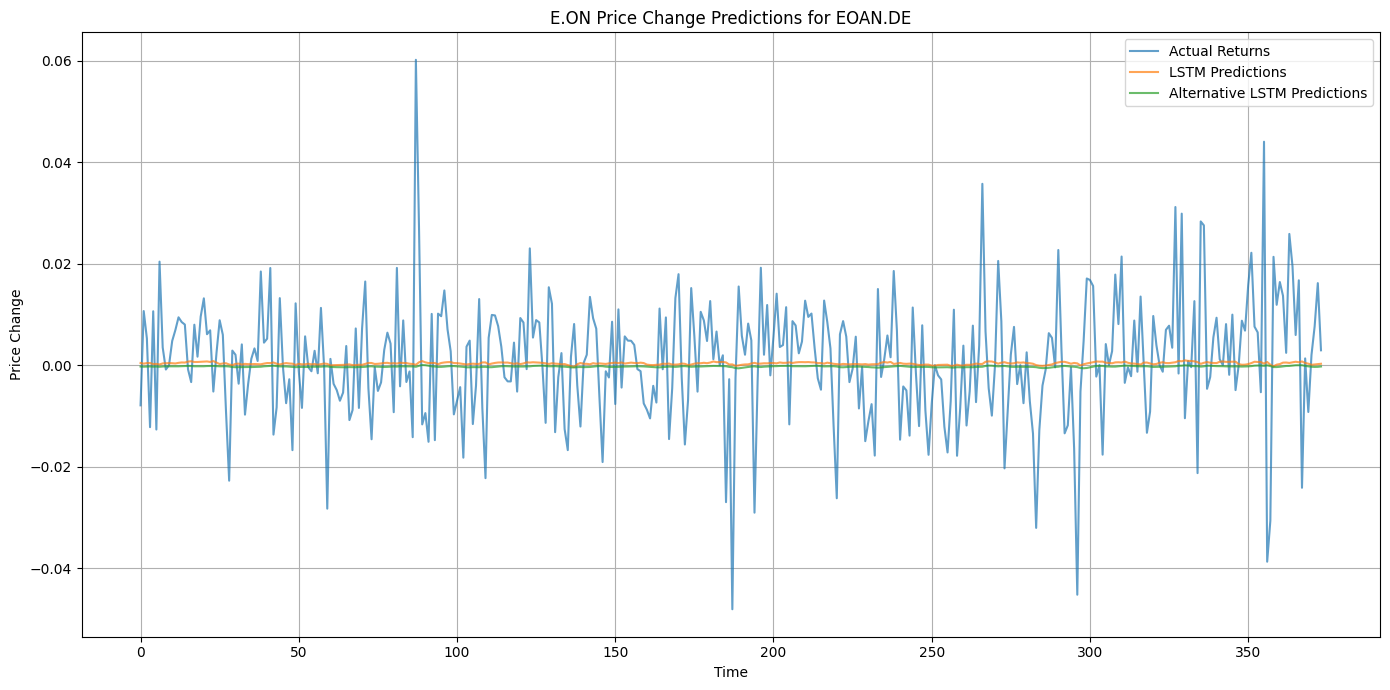

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Metrics and visualization
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Reshape input data for RNN models (samples, time steps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model 1: Basic RNN with LSTM
def create_lstm_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, bidirectional=USE_BIDIRECTIONAL, layers=LSTM_LAYERS, learning_rate=LEARNING_RATE):
    model = Sequential()
    
    # First layer
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=(layers > 1)), input_shape=(X_train.shape[1], 1)))
    else:
        model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    
    # Additional layers if requested
    for i in range(layers-1):
        if i < layers-2:  # All but last layer return sequences
            if bidirectional:
                model.add(Bidirectional(LSTM(units, return_sequences=True)))
            else:
                model.add(LSTM(units, return_sequences=True))
        else:  # Last LSTM layer
            if bidirectional:
                model.add(Bidirectional(LSTM(units)))
            else:
                model.add(LSTM(units))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Model 2: Alternative LSTM model (without attention)
def create_lstm_alternative_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    inputs = Input(shape=(X_train.shape[1], 1))
    x = LSTM(units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Set number of epochs for faster training
epochs = EPOCHS
# Model 1: Basic RNN with LSTM
def create_lstm_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, bidirectional=USE_BIDIRECTIONAL, layers=LSTM_LAYERS, learning_rate=LEARNING_RATE):
    """
    Erstellt ein LSTM-Modell für Zeitreihenvorhersage.
    
    Parameter:
        units (int): Anzahl der Neuronen in jeder LSTM-Schicht
        dropout_rate (float): Regularisierungsparameter zur Vermeidung von Überanpassung
        bidirectional (bool): Ob bidirektionale LSTM-Schichten verwendet werden sollen
        layers (int): Anzahl der LSTM-Schichten im Modell
        learning_rate (float): Schrittweite für den Optimizer Adam
    """
    model = Sequential()
    
    # First layer
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=(layers > 1)), input_shape=(X_train.shape[1], 1)))
    else:
        model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    
    # Additional layers if requested
    for i in range(layers-1):
        if i < layers-2:  # All but last layer return sequences
            if bidirectional:
                model.add(Bidirectional(LSTM(units, return_sequences=True)))
            else:
                model.add(LSTM(units, return_sequences=True))
        else:  # Last LSTM layer
            if bidirectional:
                model.add(Bidirectional(LSTM(units)))
            else:
                model.add(LSTM(units))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Model 2: Alternative LSTM model (without attention)
def create_lstm_alternative_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    """
    Erstellt ein alternatives LSTM-Modell mit fester Architektur (zwei LSTM-Schichten).
    This model differs from the basic model by having a fixed architecture with two LSTM layers.
    It uses a Functional API implementation instead of Sequential, which allows for more 
    flexibility in creating the model architecture.
    Parameter:
        units (int): Anzahl der Neuronen in jeder LSTM-Schicht
        dropout_rate (float): Regularisierungsparameter zur Vermeidung von Überanpassung
        learning_rate (float): Schrittweite für den Optimizer Adam
    """
    inputs = Input(shape=(X_train.shape[1], 1))
    x = LSTM(units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Set number of epochs for faster training
epochs = EPOCHS

# Train LSTM model with early stopping
print("\nTraining LSTM model...")
lstm_model = create_lstm_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, bidirectional=USE_BIDIRECTIONAL, layers=LSTM_LAYERS, learning_rate=LEARNING_RATE)
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1
)

# Train alternative LSTM model
print("\nTraining alternative LSTM model...")
alternative_model = create_lstm_alternative_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE)

history_alternative = alternative_model.fit(
    X_train_reshaped, y_train,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate both models
print("\nGenerating predictions...")
lstm_predictions = lstm_model.predict(X_test_reshaped)
alternative_predictions = alternative_model.predict(X_test_reshaped)

# Calculate metrics
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
alternative_mse = mean_squared_error(y_test, alternative_predictions)
alternative_mae = mean_absolute_error(y_test, alternative_predictions)

print(f"\nLSTM Model - MSE: {lstm_mse:.6f}, MAE: {lstm_mae:.6f}")
print(f"Alternative LSTM Model - MSE: {alternative_mse:.6f}, MAE: {alternative_mae:.6f}")

# Plot training history
plt.figure(figsize=MEDIUM_FIG_SIZE)
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_alternative.history['loss'], label='Training Loss')
plt.plot(history_alternative.history['val_loss'], label='Validation Loss')
plt.title('Alternative LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=LARGE_FIG_SIZE)
plt.plot(y_test, label='Actual Returns', alpha=0.7)
plt.plot(lstm_predictions, label='LSTM Predictions', alpha=0.7)
plt.plot(alternative_predictions, label='Alternative LSTM Predictions', alpha=0.7)
# Die folgende Zeile wurde entfernt, da sie auf eine noch nicht definierte Variable zugreift
# plt.plot(attention_predictions, label='Attention LSTM Predictions', alpha=0.7)
plt.title(f'{ASSET_NAME} Price Change Predictions for {ticker}')
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Explanation of LSTM Model Architectures:

#### Bidirectional LSTM (`create_lstm_model`):
- **Bidirectionality**: Analyzes the time series both forwards and backwards to capture more contextual information.
- **Multi-layer Architecture**: Supports multiple LSTM layers for more complex pattern detection.
- **Dropout Regularization**: Prevents overfitting by randomly turning off neurons during training.

#### Stacked LSTM (`create_lstm_alternative_model`):
- **Sequential Processing**: First LSTM layer returns sequences (`return_sequences=True`).
- **Hierarchical Feature Extraction**: Second LSTM layer processes the outputs of the first layer.

#### Training and Evaluation:
- **Early Stopping**: Ends training when no improvement occurs to prevent overfitting.
- **Validation Split**: 20% of training data is used for validation during training.
- **Metrics**: MSE (Mean Squared Error) and MAE (Mean Absolute Error) for evaluating model performance.

The charts show:
1. **Training History**: Loss on training and validation data over epochs.
2. **Prediction Comparison**: Comparison of model predictions with actual returns.

**Further Resources:**
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Bidirectional LSTM in Keras](https://keras.io/api/layers/recurrent_layers/bidirectional/)
- [Early Stopping Documentation](https://keras.io/api/callbacks/early_stopping/)

## Attention Mechanism

Attention mechanisms allow the model to focus on relevant parts of the input sequence. This can be especially helpful for time series with longer dependencies.

[TensorFlow Attention Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention)


Training LSTM model with attention mechanism...


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 50, 64)    │     16,896 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 50, 64)    │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 50, 64)    │     33,024 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 50, 64)    │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 50, 64)    │          0 │ dropout_13[0][0], │
│ (Attention)         │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3200)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      3,201 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,121 (207.50 KB)

 Trainable params: 53,121 (207.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.3417e-04 - val_loss: 2.0209e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.3417e-04 - val_loss: 2.0209e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1482e-04 - val_loss: 2.0178e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1482e-04 - val_loss: 2.0178e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0484e-04 - val_loss: 2.0616e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0484e-04 - val_loss: 2.0616e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1308e-04 - val_loss: 2.2036e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1308e-04 - val_loss: 2.2036e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2465e-04 - val_loss: 2.0152e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2465e-04 - val_loss: 2.0152e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1606e-04 

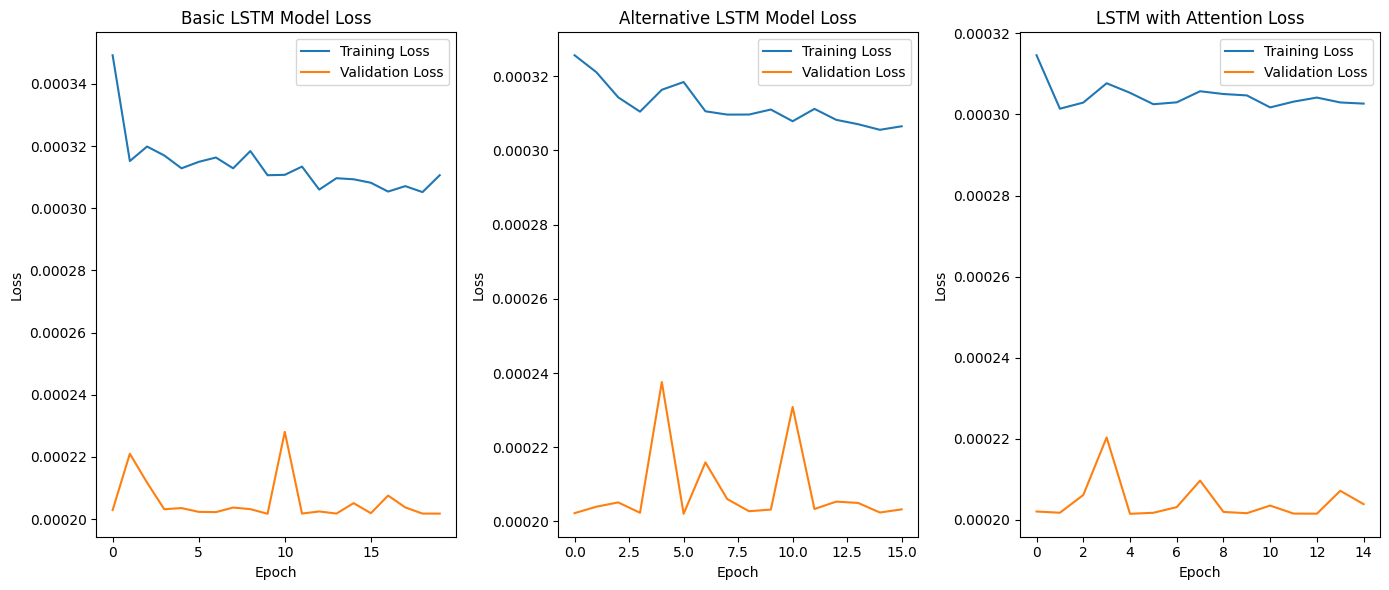

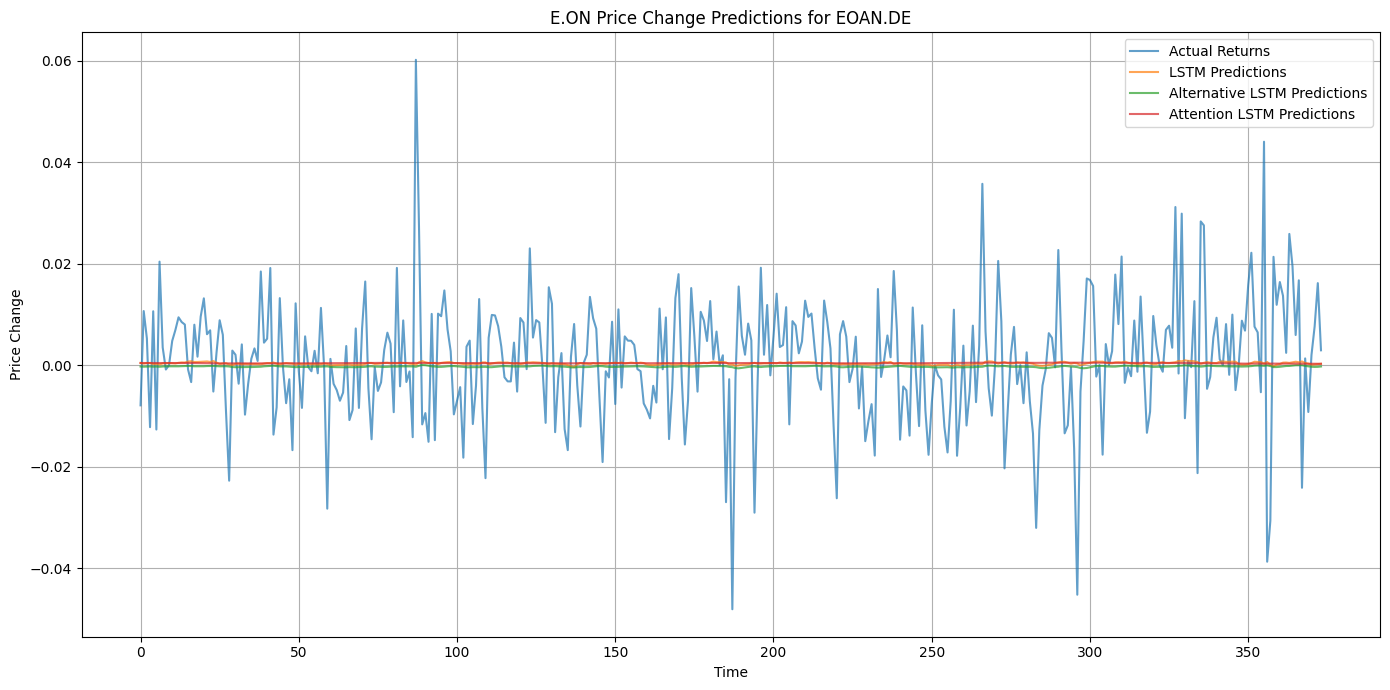

In [11]:
from tensorflow.keras.layers import Attention, Concatenate

# Import the Attention layer

# Create an LSTM model with attention mechanism
def create_lstm_attention_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    # Define input
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # LSTM layers
    lstm_layer1 = LSTM(units, return_sequences=True)(input_layer)
    lstm_layer1 = Dropout(dropout_rate)(lstm_layer1)
    lstm_layer2 = LSTM(units, return_sequences=True)(lstm_layer1)
    lstm_layer2 = Dropout(dropout_rate)(lstm_layer2)
    
    # Apply attention mechanism
    attention = Attention()([lstm_layer2, lstm_layer2])
    
    # Flatten the attention output
    attention_flatten = tf.keras.layers.Flatten()(attention)
    
    # Dense output layer
    output_layer = Dense(1)(attention_flatten)
    
    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    # This model uses attention to focus on the most relevant time steps in the sequence
    # The attention mechanism allows the model to weigh different time steps differently
    # Particularly useful for time series where some historical points are more relevant than others
    model.summary()  # Display the model architecture
    return model

# Create and train the attention model
print("\nTraining LSTM model with attention mechanism...")
attention_model = create_lstm_attention_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE)
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history_attention = attention_model.fit(
    X_train_reshaped, y_train,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1
)

# Generate predictions using attention model
attention_predictions = attention_model.predict(X_test_reshaped)

# Calculate metrics for attention model
attention_mse = mean_squared_error(y_test, attention_predictions)
attention_mae = mean_absolute_error(y_test, attention_predictions)

print(f"\nLSTM with Attention - MSE: {attention_mse:.6f}, MAE: {attention_mae:.6f}")
print(f"Basic LSTM - MSE: {lstm_mse:.6f}, MAE: {lstm_mae:.6f}")
print(f"Alternative LSTM - MSE: {alternative_mse:.6f}, MAE: {alternative_mae:.6f}")

# Plot training history for all three models
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Basic LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_alternative.history['loss'], label='Training Loss')
plt.plot(history_alternative.history['val_loss'], label='Validation Loss')
plt.title('Alternative LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_attention.history['loss'], label='Training Loss')
plt.plot(history_attention.history['val_loss'], label='Validation Loss')
plt.title('LSTM with Attention Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions vs actual values for all models
plt.figure(figsize=LARGE_FIG_SIZE)
plt.plot(y_test, label='Actual Returns', alpha=0.7)
plt.plot(lstm_predictions, label='LSTM Predictions', alpha=0.7)
plt.plot(alternative_predictions, label='Alternative LSTM Predictions', alpha=0.7)
plt.plot(attention_predictions, label='Attention LSTM Predictions', alpha=0.7)
plt.title(f'{ASSET_NAME} Price Change Predictions for {ticker}')
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### How the Attention Mechanism Works:
- **Selective Focus**: Attention allows the model to give more weight to relevant time points in the sequence.
- **Implementation**: Keras' built-in `attention` layer, which takes two sequences as input (query and value).
- **Architecture**: Two LSTM layers with attention followed by flattening and a dense layer.

#### Advantages over Standard LSTM:
- **Improved Long-term Dependencies**: Better considering of relevant information over longer time periods.
- **Interpretability**: Attention weights can be visualized to understand which time points the model considers important.
- **Training Efficiency**: Can converge faster and often achieve better results.


---

## Autoregressive Predictions and Model Comparison

Implementation of [autoregressive predictions (which use their own previous predictions)](https://otexts.com/fpp2/AR.html)  and compare our models with comprehensive metrics.

Generating autoregressive predictions...

Evaluation metrics for one-step predictions:
LSTM Model:
MAE: 0.008948
MSE: 0.000146
RMSE: 0.012067
MAPE: 10172910.815131

Alternative LSTM Model:
MAE: 0.009002
MSE: 0.000147
RMSE: 0.012124
MAPE: 8394305.259816

Attention LSTM Model:
MAE: 0.008961
MSE: 0.000146
RMSE: 0.012073
MAPE: 11626491.631791

Evaluation metrics for autoregressive predictions:
LSTM Model:
MAE: 0.008959
MSE: 0.000146
RMSE: 0.012074
MAPE: 9312166.523260

Alternative LSTM Model:
MAE: 0.009004
MSE: 0.000147
RMSE: 0.012126
MAPE: 9084082.632036

Attention LSTM Model:
MAE: 0.008956
MSE: 0.000146
RMSE: 0.012070
MAPE: 11832750.604953

Evaluation metrics for one-step predictions:
LSTM Model:
MAE: 0.008948
MSE: 0.000146
RMSE: 0.012067
MAPE: 10172910.815131

Alternative LSTM Model:
MAE: 0.009002
MSE: 0.000147
RMSE: 0.012124
MAPE: 8394305.259816

Attention LSTM Model:
MAE: 0.008961
MSE: 0.000146
RMSE: 0.012073
MAPE: 11626491.631791

Evaluation metrics for autoregressive predictions:
LS

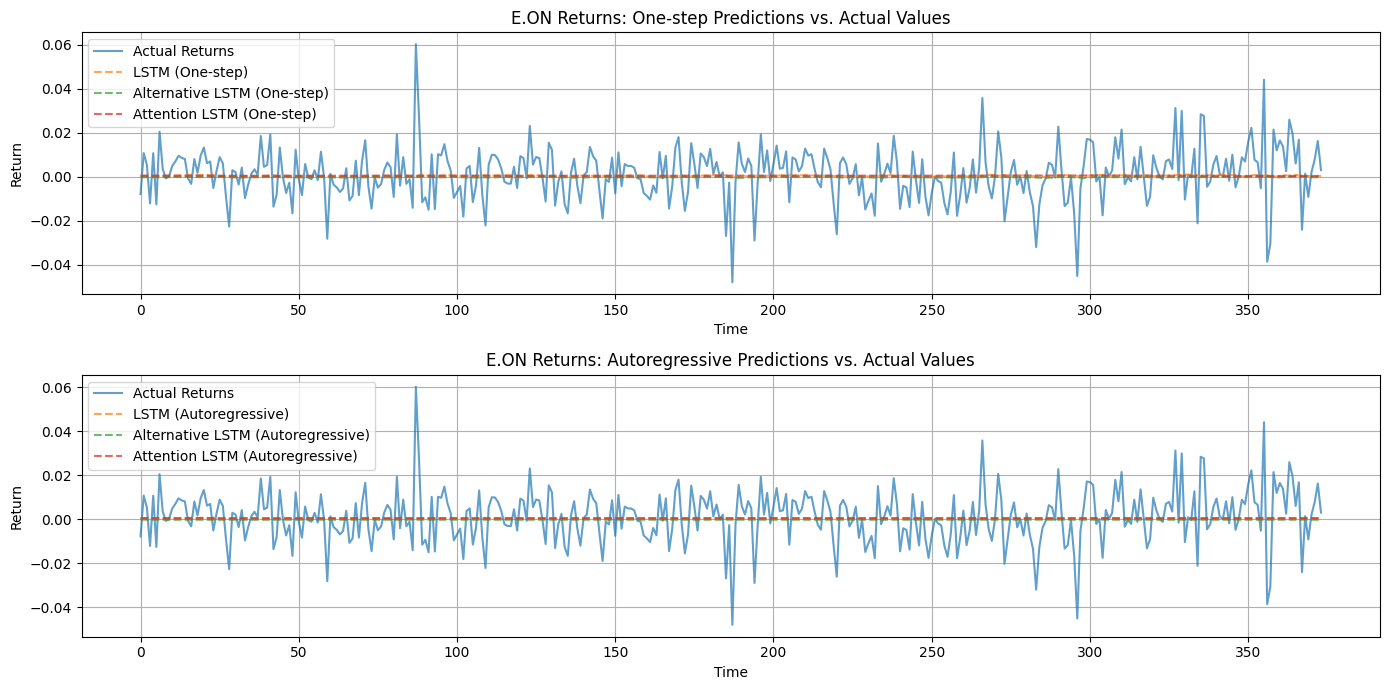

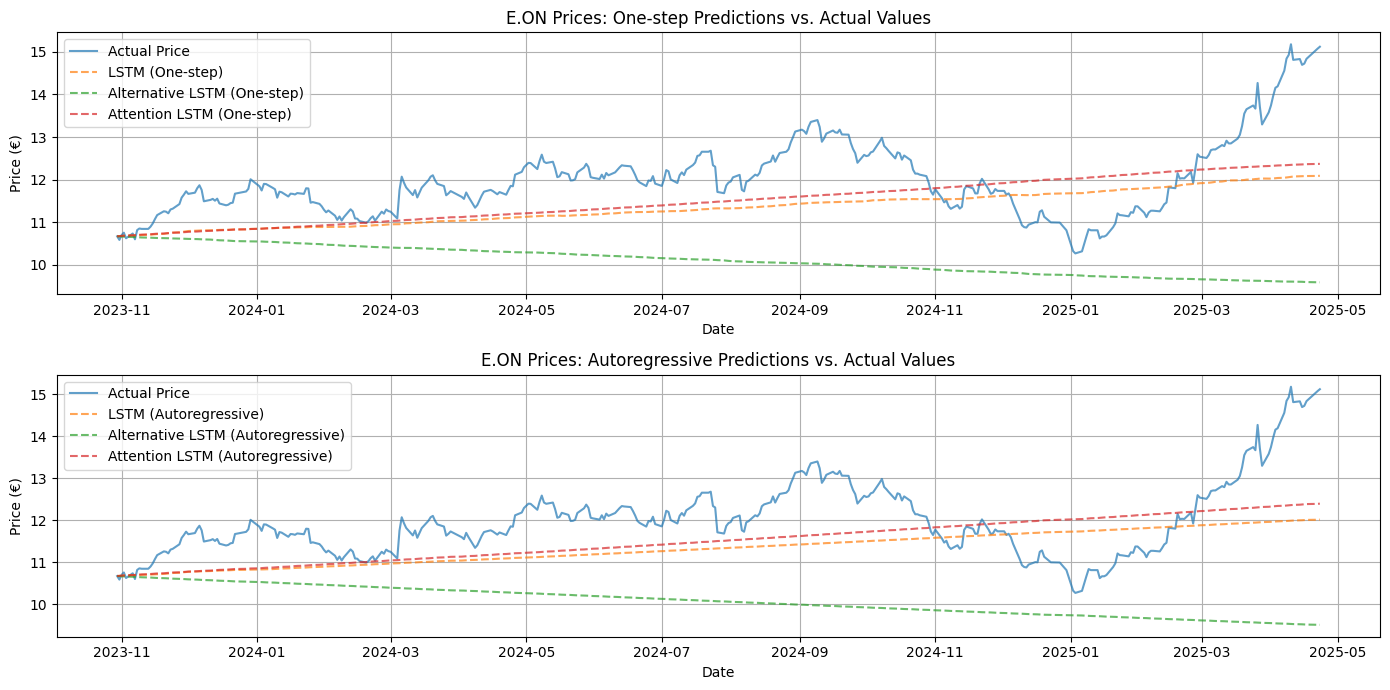

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Implement autoregressive prediction for comparing with one-step predictions
def autoregressive_predict(model, X_test, window_size, n_predictions):
    """
    Generate autoregressive predictions using a trained model.
    
    Parameters:
    -----------
    model : trained TensorFlow/Keras model
    X_test : test data, first window will be used as seed
    window_size : size of the sliding window
    n_predictions : number of predictions to generate
    
    Returns:
    --------
    Array of predictions of shape (n_predictions,)
    """
    predictions = []
    current_window = X_test[0].copy()
    
    for _ in range(n_predictions):
        # Reshape for the model (samples, time steps, features)
        x = current_window.reshape(1, window_size, 1)
        
        # Generate prediction for the next time step
        next_pred = model.predict(x, verbose=0)[0][0]
        predictions.append(next_pred)
        
        # Update window: remove first element and add the prediction
        current_window = np.append(current_window[1:], next_pred)
    
    return np.array(predictions)

# Use window size from existing data
window_size = X_train.shape[1]

# Generate autoregressive predictions for all models
print("Generating autoregressive predictions...")
n_predictions = len(y_test)
lstm_auto_predictions = autoregressive_predict(lstm_model, X_test, window_size, n_predictions)
alternative_auto_predictions = autoregressive_predict(alternative_model, X_test, window_size, n_predictions)
attention_auto_predictions = autoregressive_predict(attention_model, X_test, window_size, n_predictions)

# Calculate evaluation metrics

def calculate_metrics(y_true, y_pred):
    """Calculate common evaluation metrics for time series predictions."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    # MAPE can cause issues with zeros, so we add a small epsilon
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-10))) * 100
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Calculate and display metrics
print("\nEvaluation metrics for one-step predictions:")
print("LSTM Model:")
lstm_metrics = calculate_metrics(y_test, lstm_predictions)
for metric, value in lstm_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nAlternative LSTM Model:")
alt_metrics = calculate_metrics(y_test, alternative_predictions)
for metric, value in alt_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nAttention LSTM Model:")
att_metrics = calculate_metrics(y_test, attention_predictions)
for metric, value in att_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluation metrics for autoregressive predictions:")
print("LSTM Model:")
lstm_auto_metrics = calculate_metrics(y_test, lstm_auto_predictions)
for metric, value in lstm_auto_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nAlternative LSTM Model:")
alt_auto_metrics = calculate_metrics(y_test, alternative_auto_predictions)
for metric, value in alt_auto_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nAttention LSTM Model:")
att_auto_metrics = calculate_metrics(y_test, attention_auto_predictions)
for metric, value in att_auto_metrics.items():
    print(f"{metric}: {value:.6f}")

# Visualize relative price changes
plt.figure(figsize=LARGE_FIG_SIZE)

# Plot one-step predictions
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual Returns', alpha=0.7)
plt.plot(lstm_predictions, label='LSTM (One-step)', alpha=0.7, linestyle='--')
plt.plot(alternative_predictions, label='Alternative LSTM (One-step)', alpha=0.7, linestyle='--')
plt.plot(attention_predictions, label='Attention LSTM (One-step)', alpha=0.7, linestyle='--')
plt.title(f'{ASSET_NAME} Returns: One-step Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)

# Plot autoregressive predictions
plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual Returns', alpha=0.7)
plt.plot(lstm_auto_predictions, label='LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.plot(alternative_auto_predictions, label='Alternative LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.plot(attention_auto_predictions, label='Attention LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.title(f'{ASSET_NAME} Returns: Autoregressive Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Reconstruct absolute prices
def reconstruct_prices(initial_price, returns):
    """Reconstruct absolute prices from returns and an initial price."""
    prices = [initial_price]
    current_price = initial_price
    
    # Flatten predictions if they're in 2D array format (n, 1)
    if isinstance(returns, np.ndarray) and returns.ndim > 1:
        returns = returns.flatten()
    
    for ret in returns:
        current_price = current_price * (1 + ret)
        prices.append(current_price)
    
    return np.array(prices)

# Extract closing prices from stock data
if isinstance(stock_data.columns, pd.MultiIndex):
    close_prices = stock_data[('Close', ticker)]
else:
    close_prices = stock_data['Close']

# Get the last price from training set as initial price
split_point = int(len(returns) * TRAIN_RATIO)
initial_price = close_prices.iloc[split_point]

# Reconstruct absolute prices
actual_prices = reconstruct_prices(initial_price, y_test)
lstm_pred_prices = reconstruct_prices(initial_price, lstm_predictions)
alt_pred_prices = reconstruct_prices(initial_price, alternative_predictions)
attention_pred_prices = reconstruct_prices(initial_price, attention_predictions)
lstm_auto_pred_prices = reconstruct_prices(initial_price, lstm_auto_predictions)
alt_auto_pred_prices = reconstruct_prices(initial_price, alternative_auto_predictions)
attention_auto_pred_prices = reconstruct_prices(initial_price, attention_auto_predictions)

# Create time index for visualization
test_dates = returns.index[split_point:split_point+len(y_test)+1]

# Visualize absolute prices
plt.figure(figsize=LARGE_FIG_SIZE)

# Plot one-step prediction prices
plt.subplot(2, 1, 1)
plt.plot(test_dates, actual_prices, label='Actual Price', alpha=0.7)
plt.plot(test_dates, lstm_pred_prices, label='LSTM (One-step)', alpha=0.7, linestyle='--')
plt.plot(test_dates, alt_pred_prices, label='Alternative LSTM (One-step)', alpha=0.7, linestyle='--')
plt.plot(test_dates, attention_pred_prices, label='Attention LSTM (One-step)', alpha=0.7, linestyle='--')
plt.title(f'{ASSET_NAME} Prices: One-step Predictions vs. Actual Values')
plt.xlabel('Date')
plt.ylabel(f'Price ({CURRENCY})')
plt.legend()
plt.grid(True)

# Plot autoregressive prediction prices
plt.subplot(2, 1, 2)
plt.plot(test_dates, actual_prices, label='Actual Price', alpha=0.7)
plt.plot(test_dates, lstm_auto_pred_prices, label='LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.plot(test_dates, alt_auto_pred_prices, label='Alternative LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.plot(test_dates, attention_auto_pred_prices, label='Attention LSTM (Autoregressive)', alpha=0.7, linestyle='--')
plt.title(f'{ASSET_NAME} Prices: Autoregressive Predictions vs. Actual Values')
plt.xlabel('Date')
plt.ylabel(f'Price ({CURRENCY})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Explanation of Autoregressive Predictions and Evaluation:

#### Autoregressive Predictions vs. One-Step Predictions:
- **One-Step Predictions**: Use actual historical data to predict each next value.
- **Autoregressive Predictions**: Use their own previous predictions as input for future predictions.
- **Implementation**: The `autoregressive_predict()` function continuously updates the input window with its own predictions.

#### Comprehensive Model Evaluation:
- **Metrics**: [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (Mean Absolute Error), [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (Mean Squared Error), [RMSE](https://en.wikipedia.org/wiki/Root_mean_square_deviation) (Root Mean Squared Error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (Mean Absolute Percentage Error)
- **Comparison by Model Type**: All three model architectures are compared for both one-step and autoregressive predictions.
- **Visualization**: Daily returns and absolute prices are visualized for both prediction types.

#### Price Reconstruction:
- **Method**: The `reconstruct_prices()` function calculates absolute prices from the predicted returns.
- **Application**: Shows how small prediction errors in returns can affect absolute prices.
- **Insight**: Autoregressive predictions often have larger deviations over longer periods as errors propagate.

#### Practical Relevance:
- **One-Step Predictions**: Better for short-term forecasts and as an indicator for the direction of the next price movement.
- **Autoregressive Predictions**: Test the robustness of the model and its ability to predict longer trends.
- **Combination**: In practice, a combination of both approaches may be useful depending on the time horizon.


[Autoregressive Models in Deep Learning](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)
[TensorFlow Forecasting Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)

---

## Summary and Next Steps

### Key Insights:
- LSTM networks can detect patterns in time series, however, stock price prediction remains challenging due to various market factors.
- Bidirectional LSTMs and attention mechanisms can improve prediction quality.
- Autoregressive predictions highlight the limitations of the models, especially for longer-term forecasts.

### Possible Extensions:
1. **Multivariate Models**: Include additional factors such as trading volume, social media sentiment, or macroeconomic indicators.
2. **Ensemble Methods**: Combine different models for more robust predictions.
3. **Hyperparameter Optimization**: Systematic search for optimal parameters using Grid Search or Bayesian Optimization.
4. **Transformer Models**: Implement more modern architectures like Transformers for time series predictions.
5. **Volatility Prediction**: Predict expected volatility in addition to price direction.



Training with window size: 10
Epoch 1/20


C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.5502e-04 - val_loss: 2.6127e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.5502e-04 - val_loss: 2.6127e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8826e-04 - val_loss: 2.9729e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8826e-04 - val_loss: 2.9729e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2213e-04 - val_loss: 2.4900e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2213e-04 - val_loss: 2.4900e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0910e-04 - val_loss: 2.4712e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0910e-04 - val_loss: 2.4712e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9695e-04 - val_loss: 2.4860e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9695e-04 - val_loss: 2.4860e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2642e-04 - val_loss: 2.5536e-

C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.8140e-04 - val_loss: 2.3819e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.8140e-04 - val_loss: 2.3819e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4874e-04 - val_loss: 2.3054e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4874e-04 - val_loss: 2.3054e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.2033e-04 - val_loss: 2.3614e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.2033e-04 - val_loss: 2.3614e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5828e-04 - val_loss: 2.3177e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5828e-04 - val_loss: 2.3177e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0069e-04 - val_loss: 2.2836e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0069e-04 - val_loss: 2.2836e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.1191e-04 - val_loss:

C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.3144e-04 - val_loss: 2.0588e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.3144e-04 - val_loss: 2.0588e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8342e-04 - val_loss: 2.0766e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8342e-04 - val_loss: 2.0766e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.2766e-04 - val_loss: 2.0722e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.2766e-04 - val_loss: 2.0722e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1777e-04 - val_loss: 2.0175e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1777e-04 - val_loss: 2.0175e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.4145e-04 - val_loss: 2.0184e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.4145e-04 - val_loss: 2.0184e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.3193e-04 - val_loss:

C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.6032e-04 - val_loss: 2.1799e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.6032e-04 - val_loss: 2.1799e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.2316e-04 - val_loss: 2.0197e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.2316e-04 - val_loss: 2.0197e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.1995e-04 - val_loss: 2.0450e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.1995e-04 - val_loss: 2.0450e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.5117e-04 - val_loss: 2.0142e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.5117e-04 - val_loss: 2.0142e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.8185e-04 - val_loss: 2.0153e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.8185e-04 - val_loss: 2.0153e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.1934e-04 - val_loss:

C:\Users\Marc\AppData\Local\Temp\ipykernel_9440\1770130350.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(returns[i+window_size])
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.6602e-04 - val_loss: 2.3525e-04
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.6602e-04 - val_loss: 2.3525e-04
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.0928e-04 - val_loss: 2.0470e-04
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.0928e-04 - val_loss: 2.0470e-04
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.8303e-04 - val_loss: 2.0234e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.8303e-04 - val_loss: 2.0234e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2.7582e-04 - val_loss: 2.0881e-04
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2.7582e-04 - val_loss: 2.0881e-04
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.0152e-04 - val_loss: 2.0220e-04
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.0152e-04 - val_loss: 2.0220e-04
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.1424e-04 - val_loss:

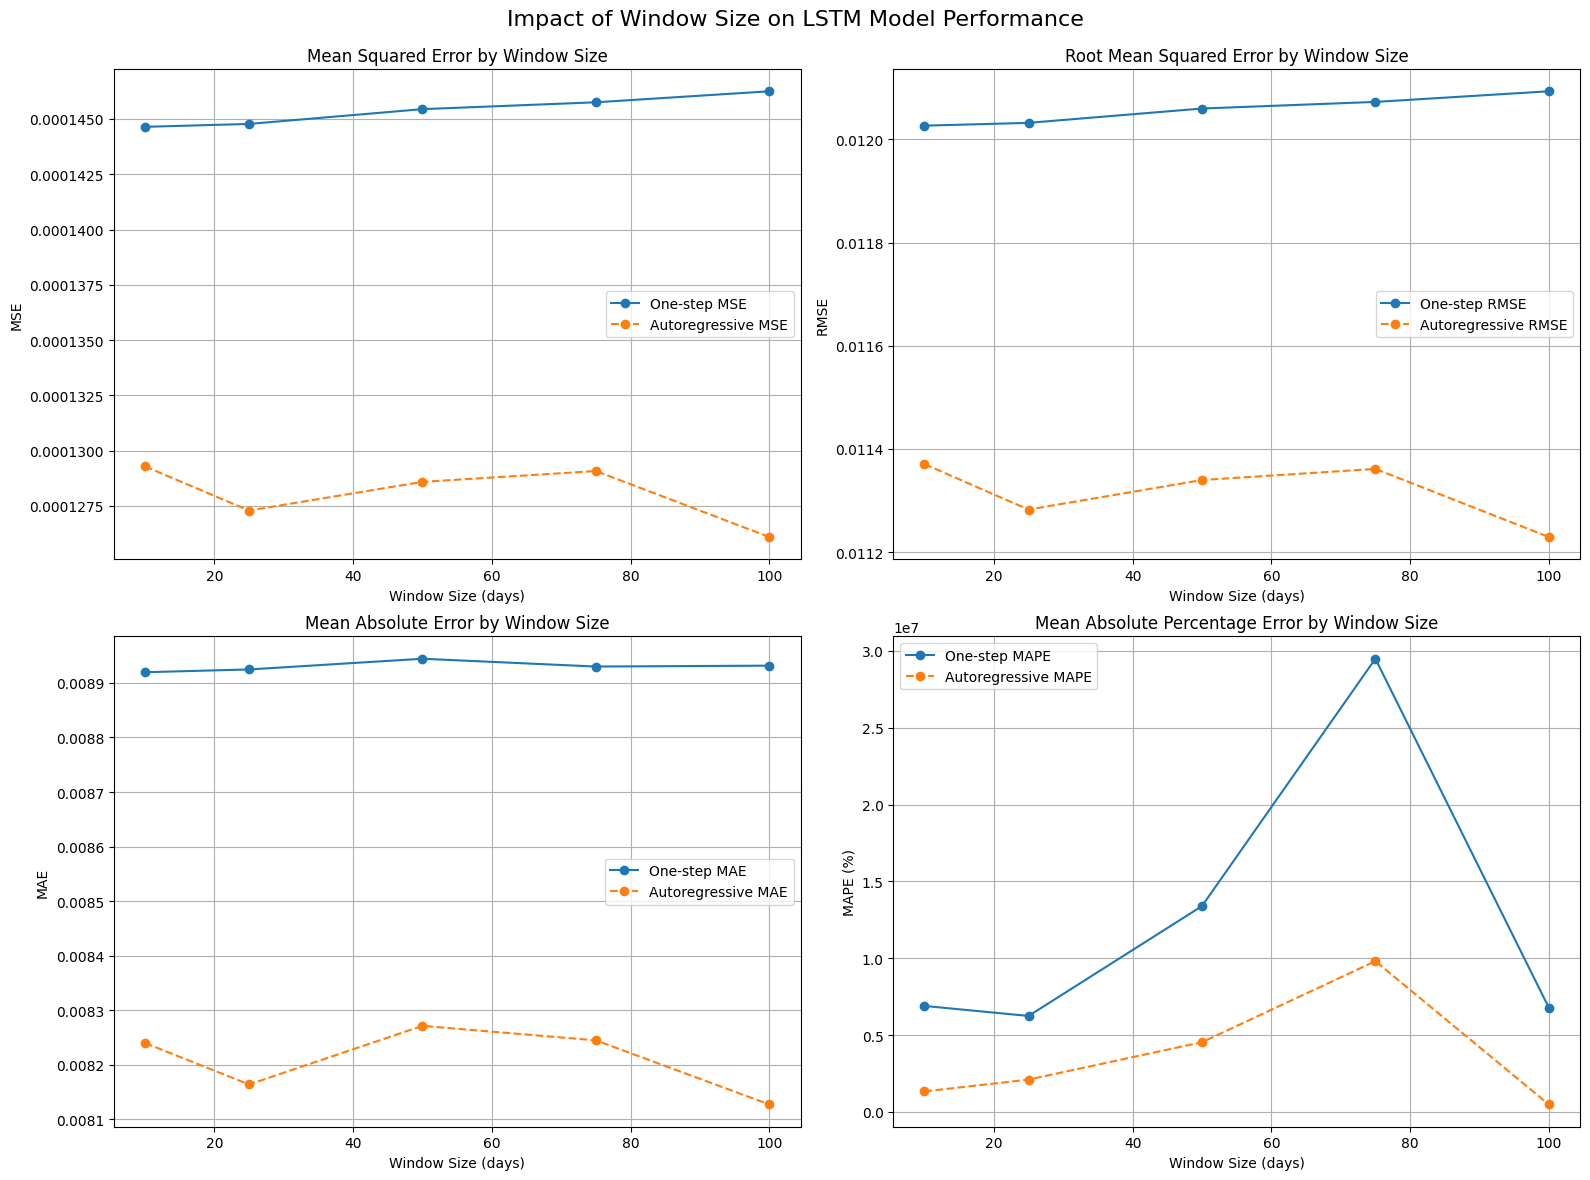

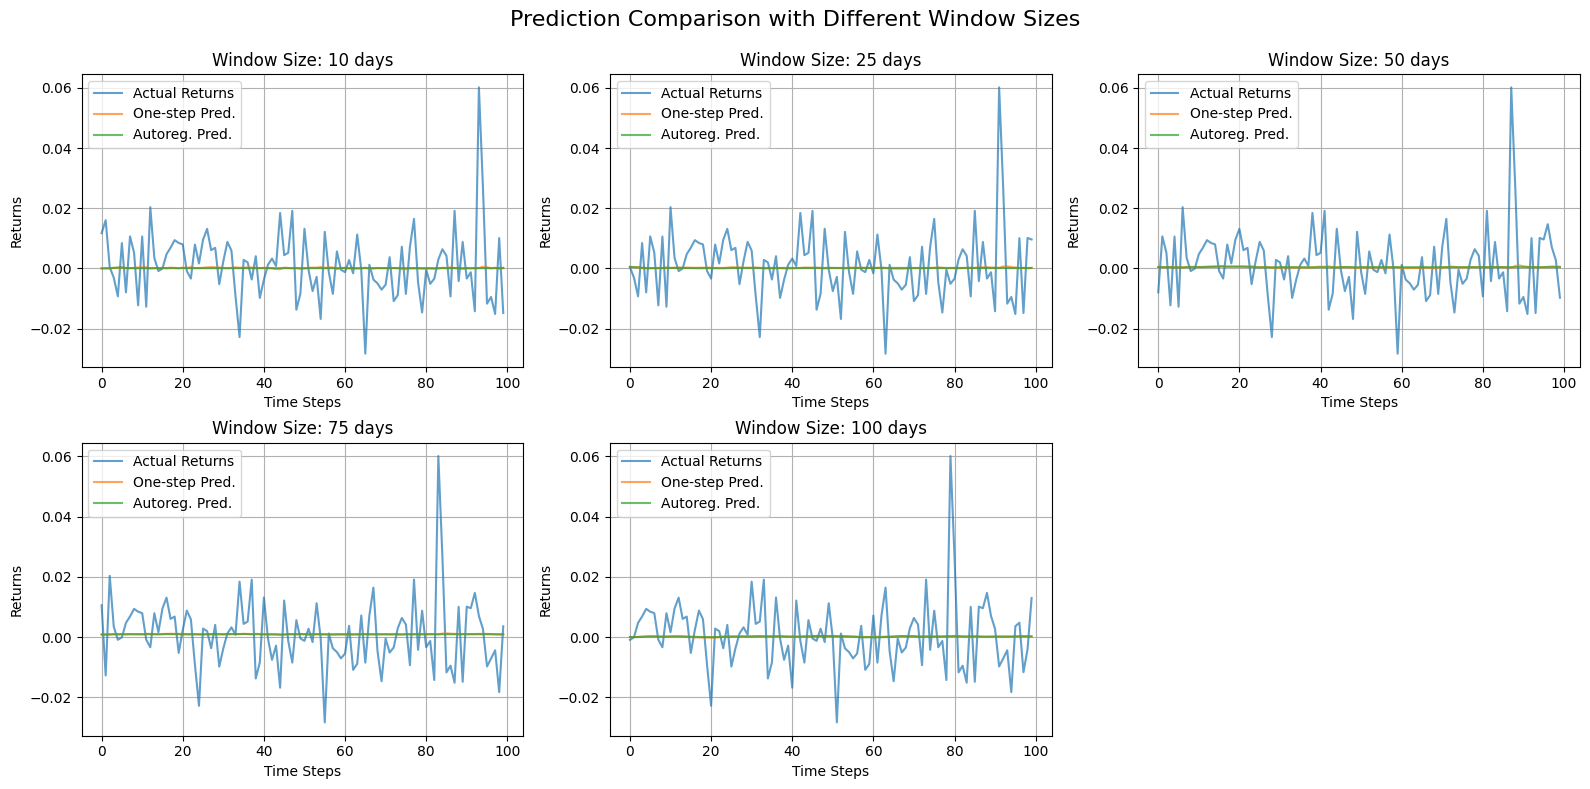

In [13]:
# Experiment with different sliding window sizes
window_sizes = TEST_WINDOW_SIZES
metrics_by_window = {}

# Function to train model with a specific window size and evaluate
def train_and_evaluate_window_size(window_size, epochs=TEST_EPOCHS):
    print(f"\nTraining with window size: {window_size}")
    
    # Generate dataset with the current window size
    X_train_w, y_train_w, X_test_w, y_test_w, returns_w = generate_dataset(
        stock_data, ticker, window_size=window_size
    )
    
    # Reshape for LSTM
    X_train_reshaped_w = X_train_w.reshape(X_train_w.shape[0], X_train_w.shape[1], 1)
    X_test_reshaped_w = X_test_w.reshape(X_test_w.shape[0], X_test_w.shape[1], 1)
    
    # Create and train the LSTM model
    model = create_lstm_model(units=LSTM_UNITS, dropout_rate=DROPOUT_RATE, bidirectional=USE_BIDIRECTIONAL, layers=LSTM_LAYERS)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train_reshaped_w, y_train_w,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Generate predictions
    predictions = model.predict(X_test_reshaped_w)
    
    # Calculate metrics
    metrics = calculate_metrics(y_test_w, predictions)
    
    # Also generate autoregressive predictions for comparison
    auto_predictions = autoregressive_predict(model, X_test_w, window_size, n_predictions=100)
    auto_metrics = calculate_metrics(y_test_w[:100], auto_predictions)
    
    return {
        'model': model,
        'history': history,
        'one_step_metrics': metrics,
        'auto_metrics': auto_metrics,
        'y_test': y_test_w,
        'predictions': predictions,
        'auto_predictions': auto_predictions
    }

# Run experiments for each window size
results = {}
for size in window_sizes:
    results[size] = train_and_evaluate_window_size(size)
    print(f"\nWindow size {size} results:")
    print("One-step prediction metrics:")
    for metric, value in results[size]['one_step_metrics'].items():
        print(f"{metric}: {value:.6f}")
    print("\nAutoregressive prediction metrics:")
    for metric, value in results[size]['auto_metrics'].items():
        print(f"{metric}: {value:.6f}")

# Plot comparison of metrics across window sizes
plt.figure(figsize=(16, 12))

# Plot MSE for different window sizes
plt.subplot(2, 2, 1)
plt.plot(window_sizes, [results[size]['one_step_metrics']['MSE'] for size in window_sizes], 'o-', label='One-step MSE')
plt.plot(window_sizes, [results[size]['auto_metrics']['MSE'] for size in window_sizes], 'o--', label='Autoregressive MSE')
plt.title('Mean Squared Error by Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Plot RMSE for different window sizes
plt.subplot(2, 2, 2)
plt.plot(window_sizes, [results[size]['one_step_metrics']['RMSE'] for size in window_sizes], 'o-', label='One-step RMSE')
plt.plot(window_sizes, [results[size]['auto_metrics']['RMSE'] for size in window_sizes], 'o--', label='Autoregressive RMSE')
plt.title('Root Mean Squared Error by Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Plot MAE for different window sizes
plt.subplot(2, 2, 3)
plt.plot(window_sizes, [results[size]['one_step_metrics']['MAE'] for size in window_sizes], 'o-', label='One-step MAE')
plt.plot(window_sizes, [results[size]['auto_metrics']['MAE'] for size in window_sizes], 'o--', label='Autoregressive MAE')
plt.title('Mean Absolute Error by Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot MAPE for different window sizes
plt.subplot(2, 2, 4)
plt.plot(window_sizes, [results[size]['one_step_metrics']['MAPE'] for size in window_sizes], 'o-', label='One-step MAPE')
plt.plot(window_sizes, [results[size]['auto_metrics']['MAPE'] for size in window_sizes], 'o--', label='Autoregressive MAPE')
plt.title('Mean Absolute Percentage Error by Window Size')
plt.xlabel('Window Size (days)')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.suptitle('Impact of Window Size on LSTM Model Performance', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

# Create a visual comparison of predictions with different window sizes
plt.figure(figsize=(16, 8))
for i, size in enumerate(window_sizes):
    if i < 5:  # Plot the first 5 window sizes
        plt.subplot(2, 3, i+1)
        plt.plot(results[size]['y_test'][:100], label='Actual Returns', alpha=0.7)
        plt.plot(results[size]['predictions'][:100], label='One-step Pred.', alpha=0.7)
        plt.plot(results[size]['auto_predictions'], label='Autoreg. Pred.', alpha=0.7)
        plt.title(f'Window Size: {size} days')
        plt.xlabel('Time Steps')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.suptitle('Prediction Comparison with Different Window Sizes', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()


## Window Size Impact

### Observations:
**Window Size Performance Trend**: The experiments demonstrate how the prediction accuracy varies with different historical window sizes.
- Smaller windows (10-25 days) react more quickly to recent changes but may miss longer-term patterns
- Medium windows (50 days) generally provide a good balance between short and long-term patterns
- Larger windows (75-100 days) capture more historical context but may include irrelevant past information

**One-Step vs. Autoregressive Predictions**:
- One-step predictions are more consistent across window sizes
- Autoregressive predictions show greater sensitivity to window size choice, especially in smaller windows

**Error Metrics Relationship**:
- MSE and RMSE typically decrease as window size increases up to an optimal point
- MAE follows a similar pattern but is less sensitive to outliers
- MAPE values highlight that percentage errors can be substantial in volatile market periods

